In [121]:
# This script should take the em_centroids h5_file and query the agglo_id
#TODO: create reference lm stack 
# TODO: change neuron for centroid in lut
# TODO: Read image information from json file
# TODO: Create functions to get info from h5 files
# Standard library imports
import os
import time
from tqdm import tqdm
import logging


# Third-party imports
import numpy as np
import pandas as pd
import h5py
import tifffile
import napari
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator
import dill
from skimage.measure import regionprops, label
from skimage.transform import SimilarityTransform

from google.cloud import bigquery
from google.auth import exceptions

# Custom imports
from brainmaps_api_fcn.equivalence_requests import EquivalenceRequests
from brainmaps_api_fcn.subvolume_requests import SubvolumeRequest
from scripts.sample_db import SampleDB
from scripts.utils.image_utils import load_tiff_as_hyperstack, save_array_as_hyperstack_tiff, warp_stack_to_plane, warp_plane_to_stack

In [4]:
def get_agglo_group_with_retry(sa, volume_id, stack_change, centroid_xyz, max_retries=5):
    """Get agglomeration group with retry mechanism."""
    for attempt in range(max_retries):
        try:
            sr = SubvolumeRequest(sa, volume_id)
            vol = sr.get_subvolume(centroid_xyz, size=[1,1,1], change_stack_id=stack_change)
            agglo_id = int(np.unique(vol[vol>0])[0])

            er = EquivalenceRequests(sa, volume_id, stack_change)
            return er.get_groups(agglo_id)
        except exceptions.RefreshError:
            if attempt == max_retries - 1:
                raise
            print(f"Try {attempt+1}/{max_retries}")
            time.sleep(attempt)


def get_neuron_segments(lut_path, neuron_id):
    """Get all segment IDs for a given neuron"""
    with h5py.File(lut_path, 'r') as f:
        neuron_path = f'neurons/neuron_{neuron_id}'
        if neuron_path not in f:
            return []

        # Get all segment IDs from the segments group
        segments = f[neuron_path]['agglo_segments'][:]
        # Convert segment IDs from strings to integers


        return segments


def get_segments_by_agglo_id(lut_path, agglo_id):
    """Get all segment IDs for a given agglomeration ID"""
    segments = []
    with h5py.File(lut_path, 'r') as f:
        # Iterate through all neurons to find matching agglo_id
        for neuron_name, neuron_group in f['neurons'].items():
            if 'agglo_id' in neuron_group.attrs:
                if neuron_group.attrs['agglo_id'] == agglo_id:
                    # Get segments from this neuron
                    if 'agglo_segments' in neuron_group:
                        segments = neuron_group['agglo_segments'][:]
                        break
    return segments


def find_neurons_in_mask(lut_path, mask_path):
    """Find neurons with centroids inside a 3d mask"""
    # Open the Paintera zarr mask
    mask = tifffile.imread(mask_path, mode='r')
    neurons_inside = []

    with h5py.File(lut_path, 'r') as f:
        for neuron_name, neuron_group in f['neurons'].items():
            # Get the neuroglancer coordinates of the centroid
            # We use ng coordinates since Paintera mask is in the same space
            centroid = neuron_group['em_centroid_ng'][:] // 16

            #print(centroid)

            # Round coordinates to integers for indexing
            x, y, z = np.round(centroid).astype(int)

            # Check if the centroid is within mask bounds
            if (0 <= x < mask.shape[2] and
                    0 <= y < mask.shape[1] and
                    0 <= z < mask.shape[0]):

                # Check if the point is inside the mask (non-zero value)
                if mask[z, y, x] > 0:
                    neuron_id = int(neuron_name.split('_')[1])
                    agglo_id = neuron_group.attrs.get('agglo_id', None)
                    neurons_inside.append({
                        'neuron_id': neuron_id,
                        'agglo_id': agglo_id,
                        'centroid_zyx': centroid[::-1]
                    })

    return neurons_inside


def get_neurons_with_attribute(lut_path, attribute_name, attribute_value, operator="=="):
    """
    Get neurons where attribute matches the comparison with threshold

    Args:
        lut_path: Path to HDF5 file
        attribute_name: Name of attribute to check
        operator: String specifying comparison ('>', '<', '>=', '<=', '==')
        threshold: Value to compare against
    """
    neuron_with_attribute = []
    operators = {
        '>': lambda x, y: x > y,
        '<': lambda x, y: x < y,
        '>=': lambda x, y: x >= y,
        '<=': lambda x, y: x <= y,
        '==': lambda x, y: x == y
    }

    if operator not in operators:
        raise ValueError(f"Operator must be one of {list(operators.keys())}")

    with h5py.File(lut_path, 'r') as f:
        for neuron, neuron_group in f['neurons'].items():
            if attribute_name in neuron_group.attrs:
                stored_value = neuron_group.attrs[attribute_name]
                if operators[operator](stored_value, attribute_value) and "agglo_id" in neuron_group.attrs:
                    # print(stored_value)
                    neuron_with_attribute.append(neuron_group.attrs["agglo_id"])
                    #print(f"Neuron {neuron}: {attribute_name} = {stored_value}")

    return neuron_with_attribute

def extract_dataset(h5_path, group_path):
    """Extract datasets and attributes from HDF5 group into a dictionary"""
    extracted_data = {}
    
    with h5py.File(h5_path, 'r') as f:
        group = f[group_path]
        
        # Get datasets
        for key, val in group.items():
            extracted_data[key] = val[()]
        
        # Get attributes
        for key, val in group.attrs.items():
            extracted_data[key] = val
            
    return extracted_data 

def apply_transformation(points, transform):
    # Convert to homogeneous coordinates
    homogeneous_points = np.column_stack((points, np.ones(len(points))))
    # Apply transformation
    transformed_points = homogeneous_points @ transform.T
    # Return to 3D coordinates
    return transformed_points[:, :3]


# Function to check if a point is within the 3D mask
def is_within_mask(point, mask):
    z, y, x = np.round(point).astype(int)
    if 0 <= z < mask.shape[0] and 0 <= y < mask.shape[1] and 0 <= x < mask.shape[2]:
        return mask[z, y, x]
    return False





In [5]:
client = bigquery.Client(project="fmi-friedrich")

# Step 1: Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path)
# Step 2: Load experiment configuration
sample_id = '20220426_RM0008_130hpf_fP1_f3'
exp = sample_db.get_sample(sample_id)


# Input: volume data
sa = r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\Reconstruction\fmi-friedrich-ebb67584e50d.json"
volume_id = r"280984173682:montano_rm2_ngff:raw_230701_seg_240316fb"
stack_change = "240705d_rsg9_spl"

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('neuron_processing.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [6]:
em_centroids_path = os.path.join(exp.paths.em_path, f"{exp.sample.id}_em_centroids.h5")


In [7]:
# Read centroids from HDF5 file and do transformation to neuroglancer
with h5py.File(em_centroids_path, 'r') as f:
    # Get centroids coordinates
    data = f['centroids/coordinates'][:]
    centroids = data[:, 1:]

    # Get transformation parameters
    transformation_matrix = f['metadata/transformations/bigwarp2neuroglancer/transformation_matrix'][:]
    rotated_cropped_stack_center_shift = f[
                                             'metadata/transformations/bigwarp2neuroglancer/rotated_cropped_stack_center_shift'][
                                         :]
    rotated_stack_center_shift = f['metadata/transformations/bigwarp2neuroglancer/rotated_stack_center_shift'][:]
    cropped_shift = f['metadata/transformations/bigwarp2neuroglancer/cropped_shift'][:]
    ng_shift = f['metadata/transformations/bigwarp2neuroglancer/ng_shift'][:]
    downsampled_factor = f['metadata/transformations/bigwarp2neuroglancer/downsampled_factor'][:]
    zyx2xyz = f['metadata/transformations/bigwarp2neuroglancer'].attrs['zyx2xyz']
    # Apply transformations to get Neuroglancer coordinates
    # 1. Center points around origin
    centered_points = centroids - rotated_cropped_stack_center_shift

    # 2. Apply transformation matrix
    transformed_centered = np.dot(centered_points, transformation_matrix.T)

    # 3. Move to target space and apply shifts
    transformed_points = (transformed_centered +
                          rotated_stack_center_shift +
                          cropped_shift)
    if f['metadata/transformations/bigwarp2neuroglancer/downsampled_factor']:
        downsampled_factor = f['metadata/transformations/bigwarp2neuroglancer/downsampled_factor'][:]
        transformed_points = transformed_points * downsampled_factor

    # 4. Convert from ZYX to XYZ if needed
    if f['metadata/transformations/bigwarp2neuroglancer'].attrs['zyx2xyz']:
        transformed_points = transformed_points[:, ::-1]

    # 5. Correct for shift in neuroglancer
    transformed_points = transformed_points + ng_shift


In [8]:
transformation_path = os.path.join(exp.paths.clem_path, f"{exp.sample.id}_transformations.h5")

In [97]:
with h5py.File(transformation_path, 'w') as hdf5_file:
    images_group = hdf5_file.create_group('images_info')
    
    # EM stack in neuroglancer
    em_stack_ng_group = images_group.create_group('em_stack_ng')
    em_stack_ng_group.attrs['path'] = volume_id
    em_stack_ng_group.attrs['mask_path'] = []
    em_stack_ng_group.attrs['voxel_size'] = [.01, 0.01, 0.025] 
    em_stack_ng_group.attrs['voxel_unit'] = 'um'
    em_stack_ng_group.attrs['dim_order'] = 'xyz'
    
        
    # EM stack downsampled
    em_stack_ds_group = images_group.create_group('em_stack_ds')
    em_stack_ds_group.attrs['path'] = os.path.join(exp.paths.em_path,'fine_aligned_downsampled_4_em_stack_cropped.tif')
    em_stack_ds_group.attrs['mask_path'] = []
    em_stack_ds_group.attrs['voxel_size'] = [.4, 0.16, 0.16]  # 16x downsampled
    em_stack_ds_group.attrs['voxel_unit'] = 'um'
    em_stack_ds_group.attrs['dim_order'] = 'zyx'
    
    # EM stack used for bw alignment 
    em_stack_bw_group = images_group.create_group('em_stack_bw')
    em_stack_bw_group.attrs['path'] = os.path.join(exp.paths.em_path, '20220426_RM0008_130hpf_fP1_f3_fine_aligned_downsampled_16_em_stack_cropped_woResin_rough_rotated_to_LM.tif')
    em_stack_bw_group.attrs['mask_path'] = os.path.join(exp.paths.em_path, '20220426_RM0008_130hpf_fP1_f3_fine_aligned_downsampled_16_em_stack_cropped_woResin_rough_rotated_to_LM_cp_mask_filtered.tif')
    em_stack_bw_group.attrs['voxel_size'] = [0.16,0.4,0.16]# changed from[.16, 0.16, 0.4] 
    em_stack_bw_group.attrs['voxel_unit'] = 'um'
    em_stack_bw_group.attrs['dim_order'] = 'zyx'
    
    # EM stack in warped into LM with BigWarp
    em_stack_warped_group = images_group.create_group('em_stack_warped')
    em_stack_warped_group.attrs['path'] = os.path.join(exp.paths.clem_path, 'em_stack_warped_fov_lm_res_lm.tif')
    em_stack_warped_group.attrs['mask_path'] = os.path.join(exp.paths.clem_path, 'em_stack_warped_fov_lm_res_lm_cp_masks.tif')
    em_stack_warped_group.attrs['voxel_size'] = [0.4,0.4,0.4]
    em_stack_warped_group.attrs['voxel_unit'] = 'um'
    em_stack_warped_group.attrs['dim_order'] = 'zyx'
    
    # LM stack raw
    lm_stack_raw_group = images_group.create_group('lm_stack_raw')
    lm_stack_raw_group.attrs['path'] = os.path.join(exp.paths.anatomy_path, 'raw', '20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_.tif')
    lm_stack_raw_group.attrs['mask_path'] = []
    lm_stack_raw_group.attrs['voxel_size'] = [1.0, 0.4, 0.4]  # [1.0, 0.4, 0.4] in µm
    lm_stack_raw_group.attrs['voxel_unit'] = 'um'
    lm_stack_raw_group.attrs['dim_order'] = 'zyx'
    
    # LM stack in bigwarp space
    lm_stack_bw_group = images_group.create_group('lm_stack_bw')
    lm_stack_bw_group.attrs['path'] = os.path.join(exp.paths.anatomy_path, 'processed', 'flipped_upsampled_clahe_20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_.tif')
    lm_stack_bw_group.attrs['mask_path'] = os.path.join(exp.paths.clem_path, 'bigwarp_output','20220426_RM0008_130hpf_fP1_f3_em_mask_cropped_woResin_rough_rotated_to_LM_fov_lm_res_lm.tif') 
    lm_stack_bw_group.attrs['voxel_size'] = [0.4, 0.4, 0.4]  # [0.4, 0.4, 0.4] in µm
    lm_stack_bw_group.attrs['voxel_unit'] = 'um'
    lm_stack_bw_group.attrs['dim_order'] = 'zyx'
    
    # LM stack reference
    lm_stack_ref_group = images_group.create_group('lm_stack_ref')
    lm_stack_ref_group.attrs['path'] = os.path.join(exp.paths.anatomy_path, 'aligned_to_reference')
    lm_stack_ref_group.attrs['mask_path'] = []
    lm_stack_ref_group.attrs['voxel_size'] = [1.0, 0.4, 0.4]  # Same as bigwarp space
    lm_stack_ref_group.attrs['voxel_unit'] = 'um'
    lm_stack_ref_group.attrs['dim_order'] = 'zyx'
    
    # LM planes 
    lm_planes_group = images_group.create_group('lm_planes')
    lm_planes_group.attrs['path'] = os.path.join(exp.paths.trials_path, 'processed', f'sum_elastic_corrected_trials_{exp.sample.id}.tif')
    lm_planes_group.attrs['mask_path'] = os.path.join(exp.paths.trials_path, 'masks', f"masks_{exp.sample.id}_cp_0-ft_0-st_0.01-resample_True-augment_False.tif")
    
    lm_planes_group.attrs['voxel_size'] = [0.4, 0.4] 
    lm_planes_group.attrs['voxel_unit'] = 'um'
    lm_planes_group.attrs['dim_order'] = 'xy'

    #### TRANSFOMRATIONS ####
    transform_group = hdf5_file.create_group('transformations')
    
    # EM space transformations
    em_group = transform_group.create_group('em_transformations')
    ng2bw_group = em_group.create_group('ng2bw')  # neuroglancer to bigwarp
    ng2ds_group = em_group.create_group('ng2ds')  # bigwarp to downsampled
    
        # ng2bw transformations
    ng2bw_group.create_dataset('transformation_matrix', data=transformation_matrix)
    ng2bw_group.create_dataset('rotated_cropped_stack_center_shift', data=rotated_cropped_stack_center_shift)
    ng2bw_group.create_dataset('rotated_stack_center_shift', data=rotated_stack_center_shift)
    ng2bw_group.create_dataset('cropped_shift', data=cropped_shift)
    ng2bw_group.create_dataset('ng_shift', data=ng_shift)
    ng2bw_group.attrs['downsampled_factor'] = downsampled_factor
    ng2bw_group.attrs['zyx2xyz'] = zyx2xyz
    
        # ng2ds transformations
    ng2ds_group.create_dataset('ng_shift', data=ng_shift)
    ng2ds_group.create_dataset('cropped_shift', data=cropped_shift)
    ng2ds_group.attrs['downsampled_factor'] = downsampled_factor
    
    # LM space transformations
    lm_group = transform_group.create_group('lm_transformations')
    raw2bw_group = lm_group.create_group('raw2bw')  # bigwarp to raw
    raw2ref = lm_group.create_group('raw2ref')  # raw to reference
    plane2bw = lm_group.create_group('plane2bw')  # raw to reference

        # raw2bw transformations
    raw2bw_group.attrs['flip_axis'] = 1  # Vertical flip (y-axis)
    raw2bw_group.attrs['upsample_z'] = 2.5  # Factor to get from 1.0 to 0.4 in z
    
        # plane2stack transformations
    doubling_factor = 2 if exp.params_lm.doubling else 1
    plane2bw.attrs['transformation_matrices'] = [os.path.join(exp.paths.trials_path, 'processed', f'registration_tform_lm_plane0{plane_nr}_lm_stack_bw_.npy') for plane_nr in range(exp.params_lm.n_planes*doubling_factor)]

    # CLEM transformation (with 
    clem_group = transform_group.create_group('clem_transformations')

        # em2lm transformations
    clem_group.attrs['rbf_interpolator_path'] = os.path.join(exp.paths.clem_path,
            f'{exp.sample.id}_em2lm_interpolator.dill')
    


In [96]:
lut_path = os.path.join(exp.paths.clem_path, f"{exp.sample.id}_lut.h5")

In [11]:
# Finding agglomeration IDs fom centroids

#with h5py.File(lut_path, 'w') as hdf5_file:
    error_neurons = []
    error_neurons_coordinates = []
    # Create metadata and store transformations
    metadata_group = hdf5_file.create_group('metadata')

    metadata_group.attrs['sample_id'] = exp.sample.id
    metadata_group.attrs['volume_id'] = volume_id
    metadata_group.attrs['stack_change'] = stack_change

    neurons_group = hdf5_file.create_group('neurons')

    # Process each neuron
    for neuron_id in tqdm(range(len(centroids)), desc="Processing neurons"):
        try:
            neuron_name = f'neuron_{neuron_id}'
            if neuron_name not in neurons_group:
                neuron_group = neurons_group.create_group(f'neuron_{neuron_id}')
                # Adding EM_CENTROID_BW and EM_CENTROID_NG
                neuron_group.create_dataset('em_centroid_bw', data=centroids[neuron_id])
                neuron_group.create_dataset('em_centroid_ng', data=transformed_points[neuron_id])
                # error_neurons.append((neuron_id, "Neuron not found in file"))
                # continue

            neuron_group = neurons_group[neuron_name]
            ng_centroid = transformed_points[neuron_id]
            print(f"Processing neuron {neuron_id} at position {ng_centroid}")

            # Get agglomeration ID and segments
            centroid_xyz = np.round(ng_centroid).astype(int)
            sr = SubvolumeRequest(sa, volume_id)
            vol = sr.get_subvolume(centroid_xyz, size=[30,30,30], change_stack_id=stack_change)

            if not np.any(vol > 0):
                error_neurons.append((neuron_id, "No agglomeration ID found at position"))
                error_neurons_coordinates.append(ng_centroid)
                continue

            unique_ids, counts = np.unique(vol[vol > 0], return_counts=True)
            total_voxels = np.sum(counts)

            # Sort IDs by count
            sort_idx = np.argsort(counts)[::-1]
            unique_ids = unique_ids[sort_idx]
            counts = counts[sort_idx]

            if counts[0] / total_voxels > 0.9:
                agglo_id = int(unique_ids[0])
                er = EquivalenceRequests(sa, volume_id, stack_change)
                agglo_group = er.get_groups(agglo_id)

                for agglo_id, segment_ids in agglo_group.items():
                    neuron_group.attrs['agglo_id'] = agglo_id
                    if 'agglo_segments' in neuron_group:
                        del neuron_group['agglo_segments']
                    neuron_group.create_dataset('agglo_segments', data=segment_ids)
                    print(f"Assigned dominant agglo_id {agglo_id} ({counts[0]/total_voxels*100:.1f}% of volume)")
            else:
                segments_length_list = []
                for id, count in zip(unique_ids, counts):
                    er = EquivalenceRequests(sa, volume_id, stack_change)
                    agglo_group = er.get_groups(int(id))

                    for aid, segments in agglo_group.items():
                        print(f"Agglo id {aid}: {count/total_voxels*100:.1f}% ({len(segments)} segments)")
                        if len(segments) > 1:
                            segments_length_list.append((aid, segments))

                if len(segments_length_list) == 1:
                    agglo_id, segment_ids = segments_length_list[0]
                    neuron_group.attrs['agglo_id'] = agglo_id
                    if 'agglo_segments' in neuron_group:
                        del neuron_group['agglo_segments']
                    neuron_group.create_dataset('agglo_segments', data=segment_ids)
                    print(f"Assigned agglo_id {agglo_id} based on segment count")
                else:
                    error_neurons.append((neuron_id, f"No dominant ID found ({len(unique_ids)} IDs present)"))
                    error_neurons_coordinates.append(ng_centroid)

        except Exception as e:
            error_neurons.append((neuron_id, str(e)))
            error_neurons_coordinates.append(ng_centroid)
            print(f"Error processing neuron {neuron_id}: {e}")

print(f"Neurons with errors: {len(error_neurons)}")


Processing neurons:   0%|          | 0/10 [00:00<?, ?it/s]

Processing neuron 0 at position [7731.34535966 9385.17245292   79.51508963]


Processing neurons:  10%|█         | 1/10 [00:04<00:43,  4.81s/it]

Assigned dominant agglo_id 16922938 (100.0% of volume)
Processing neuron 1 at position [8065.5852694  9082.63058164   98.29708354]


Processing neurons:  20%|██        | 2/10 [00:09<00:40,  5.02s/it]

Assigned dominant agglo_id 16105976 (100.0% of volume)
Processing neuron 2 at position [7241.57208238 9500.75057208  117.43935927]


Processing neurons:  30%|███       | 3/10 [00:14<00:32,  4.60s/it]

Assigned dominant agglo_id 17724294 (100.0% of volume)
Processing neuron 3 at position [7989.84278399 9946.33055187  102.9958278 ]


Processing neurons:  40%|████      | 4/10 [00:19<00:30,  5.00s/it]

Assigned dominant agglo_id 18557418 (100.0% of volume)
Processing neuron 4 at position [ 8308.25757036 10222.32383327   122.56465978]


Processing neurons:  50%|█████     | 5/10 [00:23<00:23,  4.75s/it]

Assigned dominant agglo_id 18604222 (100.0% of volume)
Processing neuron 5 at position [ 7780.61132898 10298.58605664   106.04575163]


Processing neurons:  60%|██████    | 6/10 [00:29<00:19,  4.95s/it]

Assigned dominant agglo_id 18588525 (100.0% of volume)
Processing neuron 6 at position [ 7402.26637845 10337.07183239   119.09245095]


Processing neurons:  70%|███████   | 7/10 [00:32<00:12,  4.27s/it]

Assigned dominant agglo_id 18572847 (100.0% of volume)
Processing neuron 7 at position [ 7106.25313847 10565.61682593    99.94097808]


Processing neurons:  80%|████████  | 8/10 [00:37<00:09,  4.72s/it]

Assigned dominant agglo_id 19389875 (100.0% of volume)
Processing neuron 8 at position [ 8022.64278768 10586.27844408   125.15429498]


Processing neurons:  90%|█████████ | 9/10 [00:43<00:05,  5.12s/it]

Assigned dominant agglo_id 19421304 (100.0% of volume)
Processing neuron 9 at position [7553.27841031 8727.93276047  111.04081633]


Processing neurons: 100%|██████████| 10/10 [00:48<00:00,  4.84s/it]

Assigned dominant agglo_id 16074434 (100.0% of volume)
Neurons with errors: 0


# Adding em_centroids_ds: Centroids of downsampled em stack 

In [11]:
# Extracting transformations needed
ng2ds_t = extract_dataset(transformation_path, 'transformations/em_transformations/ng2ds')            
print(ng2ds_t)

# Convert to ds and add to lut
with h5py.File(lut_path, 'r+') as f:

    for neuron_name, neuron_group in tqdm(f['neurons'].items()):
        # Get centroid from this neuron
        centroid = neuron_group['em_centroid_ng'][:]
        centroid_transformed = centroid[::-1] // ng2ds_t['downsampled_factor'] - ng2ds_t['cropped_shift']
        # Store EM centroid downsampled (ds)
        if 'em_centroid_ds' in neuron_group:
            del neuron_group['em_centroid_ds']
        neuron_group.create_dataset('em_centroid_ds', data=centroid_transformed)



{'cropped_shift': array([  0, 175,  73]), 'ng_shift': array([1, 1, 1]), 'downsampled_factor': array([16, 16, 16])}


100%|██████████| 9462/9462 [00:06<00:00, 1476.03it/s]


# Adding lm_centroids_bw: Centroids of warped em stack (proxy for lm stack centroids)

In [105]:
# Load an existing interpolator
with h5py.File(transformation_path, 'r') as f:
    rbf_interpolator_path = f['transformations/clem_transformations'].attrs['rbf_interpolator_path']
    
# Warping em centroids to lm centroids and adding to LUT    
with open(rbf_interpolator_path, 'rb') as f:
    rbf_interpolator = dill.load(f)

# Warping em centroids to lm centroids individually
with h5py.File(lut_path, 'r+') as f:
    for neuron, neuron_group in tqdm(f['neurons'].items(), desc="Warping em centroids to lm centroids"):
        if 'em_centroid_bw' in neuron_group:
            # Get EM centroid
            em_centroid = neuron_group['em_centroid_bw'][:].reshape(1, -1)
            
            # Transform to LM space
            lm_centroid = rbf_interpolator(em_centroid).flatten()
            
            # Store LM centroid
            if 'lm_centroid_bw' in neuron_group:
                del neuron_group['lm_centroid_bw']
            neuron_group.create_dataset('lm_centroid_bw', data=lm_centroid)


Warping em centroids to lm centroids: 100%|██████████| 9462/9462 [00:18<00:00, 503.51it/s] 


In [ ]:
em_centroids_bw = df["em_centroid_bw"].values
lm_centroids_bw = df["lm_centroid_bw"].values
warped_plane06_to_stack = warp_plane_to_stack(lm_planes_flipped[6], lm_stack_bw, SimilarityTransform(t_forms[6]))
warped_plane05_to_stack = warp_plane_to_stack(lm_planes_flipped[5], lm_stack_bw, SimilarityTransform(t_forms[5]))
em_centroids_array = np.array([list(centroid) for centroid in em_centroids_bw if centroid is not None])
lm_centroids_array = np.array([list(centroid) for centroid in lm_centroids_bw if centroid is not None])

In [ ]:

viewer = napari.Viewer()

viewer.add_points(em_centroids_array)
viewer.add_points(lm_centroids_array)
viewer.add_image(lm_stack_bw, blending= "additive")
viewer.add_image(warped_plane06_to_stack, blending= "additive", colormap ="green")

In [131]:
viewer.add_image(warped_plane05_to_stack, blending= "additive", colormap ="green")
viewer.add_points(cell_lm_centroid, blending= "additive", face_color="red")
viewer.add_points(cell_plane_bw_centroid, blending= "additive", face_color="blue")



<Points layer 'Points [5]' at 0x21b59e721a0>

# Adding lm_planes_ids

In [98]:
# Load transformation matrices
plane2bw_t_paths = extract_dataset(transformation_path, 'transformations/lm_transformations/plane2bw')['transformation_matrices']
print(plane2bw_t_paths)
t_forms = []
for path in plane2bw_t_paths:
    t_form = np.load(path)
    t_forms.append(t_form)
t_forms = np.array(t_forms)    

# Load plane images 
lm_planes_info = extract_dataset(transformation_path, 'images_info/lm_planes')
lm_planes = tifffile.imread(lm_planes_info['path'])[:, -1] # taking only last ones
lm_planes_flipped = np.array([np.flip(plane, axis=-1) for plane in lm_planes])

# Load plane masks (from cellpose)
lm_planes_mask = tifffile.imread(lm_planes_info['mask_path'])[:, -1] # taking last ones
lm_planes_mask_flipped = np.array([np.flip(mask, axis=-1) for mask in lm_planes_mask])


# Load lm stack bw (used for BigWarp)
lm_stack_bw_info = extract_dataset(transformation_path, 'images_info/lm_stack_bw')
lm_stack_bw = tifffile.imread(lm_stack_bw_info['path'])[:,0]
lm_stack_mask_bw = tifffile.imread(lm_stack_bw_info['mask_path'])

# Load lm stack bw
lm_stack_raw_info = extract_dataset(transformation_path, 'images_info/lm_stack_raw')
lm_stack_raw = load_tiff_as_hyperstack(lm_stack_raw_info['path'], n_channels= 2)[0]


['\\\\tungsten-nas.fmi.ch\\tungsten\\scratch\\gfriedri\\montruth\\2P_RawData\\2022-04-26\\f3\\trials\\processed\\registration_tform_lm_plane00_lm_stack_bw_.npy'
 '\\\\tungsten-nas.fmi.ch\\tungsten\\scratch\\gfriedri\\montruth\\2P_RawData\\2022-04-26\\f3\\trials\\processed\\registration_tform_lm_plane01_lm_stack_bw_.npy'
 '\\\\tungsten-nas.fmi.ch\\tungsten\\scratch\\gfriedri\\montruth\\2P_RawData\\2022-04-26\\f3\\trials\\processed\\registration_tform_lm_plane02_lm_stack_bw_.npy'
 '\\\\tungsten-nas.fmi.ch\\tungsten\\scratch\\gfriedri\\montruth\\2P_RawData\\2022-04-26\\f3\\trials\\processed\\registration_tform_lm_plane03_lm_stack_bw_.npy'
 '\\\\tungsten-nas.fmi.ch\\tungsten\\scratch\\gfriedri\\montruth\\2P_RawData\\2022-04-26\\f3\\trials\\processed\\registration_tform_lm_plane04_lm_stack_bw_.npy'
 '\\\\tungsten-nas.fmi.ch\\tungsten\\scratch\\gfriedri\\montruth\\2P_RawData\\2022-04-26\\f3\\trials\\processed\\registration_tform_lm_plane05_lm_stack_bw_.npy'
 '\\\\tungsten-nas.fmi.ch\\tungste

In [15]:
viewer = napari.Viewer()

# Add LM stack in bigwarp space
viewer.add_image(
    lm_stack_bw,
    name=f'LM stack bw',
    blending='additive'
)

# Add mask
viewer.add_labels(
    lm_stack_mask_bw,
    name=f'LM Stack Mask',
    blending = "additive"

)

# Add LM plane
viewer.add_image(
    lm_planes_flipped,
    name=f'LM Planes Flipped',
    blending='additive'
)

# Add mask
viewer.add_image(
    lm_planes_mask_flipped,
    name=f'LM Plane Masks Flipped',
    blending='additive'
)


<Image layer 'LM Plane Masks Flipped' at 0x21a977e7100>

In [99]:
# Get centroids from all planes
all_centroids_3d = []
for plane_nr in range(lm_planes_mask_flipped.shape[0]):
    # Get centroids for current plane
    plane_props = regionprops(label(lm_planes_mask_flipped[plane_nr]))
    plane_centroids = np.array([prop.centroid for prop in plane_props])
    
    # Convert to 3D coordinates (z,y,x)
    plane_centroids_3d = np.column_stack((
        np.zeros(len(plane_centroids)),  # z coordinate
        plane_centroids[:, 0],           # y coordinate
        plane_centroids[:, 1]            # x coordinate
    ))
    
    # Transform points using corresponding transformation matrix
    t_form = t_forms[plane_nr]
    transformed_centroids = apply_transformation(plane_centroids_3d, t_form)
    
    # Add to viewer with different color per plane
    viewer.add_points(
        transformed_centroids, 
        name=f'Transformed Centroids Plane {plane_nr}',
        #face_color_cycle="viridis",  # Cycle through 10 colors
        size=10
    )
    
    all_centroids_3d.append(transformed_centroids)

# Combine all transformed centroids into single array if needed
all_transformed_centroids = np.vstack(all_centroids_3d)


In [109]:
# from napari.utils.transforms import Affine
# # Loop through all planes and their transformations
# for plane_nr in range(lm_planes_flipped.shape[0]):
#     # Get current plane and transform
#     lm_plane = lm_planes_flipped[plane_nr]
#     t_form = t_forms[plane_nr]
#     
#     # Convert to napari's Affine format
#     napari_affine = Affine(affine_matrix=t_form)
#     
#     # Convert 2D plane to 3D (add z-dimension)
#     lm_plane_3d = lm_plane[np.newaxis, :, :]  # Shape becomes (1, H, W)
#     
#     # Add to viewer with different color per plane
#     viewer.add_image(
#         lm_plane_3d,
#         name=f'Tilted Plane {plane_nr}',
#         affine=napari_affine,
#         blending='additive',
#         colormap=plt.cm.viridis(plane_nr/lm_planes_flipped.shape[0]),  # Different color per plane
#         opacity=0.5
#     )


D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\layers\utils\_slice_input.py:72: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\layers\utils\_slice_input.py:72: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\layers\utils\_slice_input.py:72: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\layers\utils\_slice_input.py:72: UserWarning: Non-orthogonal slicing is being requeste

In [18]:
# for plane_nr in range(lm_planes_mask_flipped.shape[0]):
#     # Get current plane and transform
#     lm_plane = lm_planes_mask_flipped[plane_nr]
#     t_form = t_forms[plane_nr]
#     
#     # Convert to napari's Affine format
#     napari_affine = Affine(affine_matrix=t_form)
#     
#     # Convert 2D plane to 3D (add z-dimension)
#     lm_plane_3d = lm_plane[np.newaxis, :, :]  # Shape becomes (1, H, W)
#     
#     # Add to viewer with different color per plane
#     viewer.add_image(
#         lm_plane_3d,
#         name=f'Tilted Plane {plane_nr}',
#         affine=napari_affine,
#         blending='additive',
#         colormap=plt.cm.viridis(plane_nr/lm_planes_mask_flipped.shape[0]),  # Different color per plane
#         opacity=0.5
#     )


D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\layers\utils\_slice_input.py:72: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\layers\utils\_slice_input.py:72: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\layers\utils\_slice_input.py:72: UserWarning: Non-orthogonal slicing is being requested, but is not fully supported. Data is displayed without applying an out-of-slice rotation or shear component.
  warnings.warn(
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\layers\utils\_slice_input.py:72: UserWarning: Non-orthogonal slicing is being requeste

In [100]:
# Assigning lm_stack_bw_labels ##### CHECK HERE 

mapping_lm_bw_em_ng = []
with h5py.File(lut_path, "r+") as f:
    
    for neuron, neuron_info in f["neurons"].items():
        if "lm_centroid_bw" in neuron_info:
            lm_centroid_bw_ii = f["neurons"][neuron]["lm_centroid_bw"][:]
            mask_value = is_within_mask(lm_centroid_bw_ii,lm_stack_mask_bw)
            f["neurons"][neuron].attrs["lm_stack_bw_mask_label"] = mask_value
            mapping_lm_bw_em_ng.append((neuron, mask_value))

df_mapping = pd.DataFrame(mapping_lm_bw_em_ng, columns=["neuron_id", "lm_stack_bw_mask_label"])

In [101]:
df_mapping.head()

,neuron_id,lm_stack_bw_mask_label
0,neuron_0,1
1,neuron_1,2
2,neuron_10,11
3,neuron_100,126
4,neuron_1000,1280


In [102]:
with h5py.File(lut_path, "r+") as f:
    
    # Process each plane
    for plane_nr in range(lm_planes_mask_flipped.shape[0]):
        # Get centroids for current plane
        plane_props = regionprops(label(lm_planes_mask_flipped[plane_nr]))
        plane_centroids = np.array([prop.centroid for prop in plane_props])
        
        # Convert to 3D coordinates
        plane_centroids_3d = np.column_stack((
            np.zeros(len(plane_centroids)),
            plane_centroids[:, 0],
            plane_centroids[:, 1]
        ))
        
        # Transform centroids
        transformed_centroids = apply_transformation(plane_centroids_3d, t_forms[plane_nr])
        
        # Store mapping between original and transformed centroids
        for i, (orig_centroid, trans_centroid) in enumerate(zip(plane_centroids, transformed_centroids)):
            mask_value = is_within_mask(trans_centroid, lm_stack_mask_bw)
            if mask_value and mask_value > 0:    
                print(mask_value)
                neuron_id = df_mapping[df_mapping["lm_stack_bw_mask_label"]==mask_value]["neuron_id"].iloc[0] if not df_mapping[df_mapping["lm_stack_bw_mask_label"]==mask_value].empty else None
                print(neuron_id)
                if neuron_id is None:
                    continue
                if neuron_id in f["neurons"]:
                    # Store original plane centroid with plane number
                    if 'lm_centroid_plane_flip' in f["neurons"][neuron_id]:
                        del f["neurons"][neuron_id]['lm_centroid_plane_flip']
                    f["neurons"][neuron_id].create_dataset('lm_centroid_plane_flip', 
                                              data=[plane_nr, *orig_centroid])
                    
                    # Store transformed centroid
                    if 'lm_centroid_plane_bw' in f["neurons"][neuron_id]:
                        del f["neurons"][neuron_id]['lm_centroid_plane_bw']
                    f["neurons"][neuron_id].create_dataset('lm_centroid_plane_bw', 
                                              data=trans_centroid)

                print(f["neurons"][neuron_id]["lm_centroid_bw"][:])
                print(f["neurons"][neuron_id]["em_centroid_ng"][:])
                print(f["neurons"][neuron_id]["lm_centroid_plane_flip"][:])
                print(f["neurons"][neuron_id]["lm_centroid_plane_bw"][:])


7732
neuron_6821
[205.17013606 140.69302188 264.11802169]
[ 6096.20444797 11162.71437649  3310.30071485]
[  0.           7.63793103 257.07758621]
[207.38079035 140.58696562 258.54752562]
8199
neuron_7217
[203.61683426 144.07894672 186.05433887]
[6840.91186527 8380.27921996 3483.46878561]
[  0.           8.9893617  185.44680851]
[208.03912032 142.06179751 190.88524428]
7240
neuron_6377
[206.46178089 147.23550916 282.75498418]
[ 5786.70916844 11669.93532338  3157.05287846]
[  0.          12.02777778 281.91666667]
[207.07953573 144.664744   282.02318599]
8199
neuron_7217
[203.61683426 144.07894672 186.05433887]
[6840.91186527 8380.27921996 3483.46878561]
[  0.          17.51960784 180.87254902]
[207.95434254 150.13192514 186.58651107]
6786
neuron_5958
[205.05001071 147.49610312 328.33897195]
[ 5239.2556391  12960.49741019  2982.77710944]
[  0.          19.46710526 329.98684211]
[206.51239118 151.55867501 327.4520191 ]
6712
neuron_5885
[206.82769792 157.11003319 292.91322554]
[ 5607.355115

In [106]:
test_centroids = {}
neuron_id = 1028
with h5py.File(lut_path, "r") as f:
    test_centroids["lm_centroid_bw"] = f["neurons"][f"neuron_{neuron_id}"]["lm_centroid_bw"][:]
    test_centroids["lm_centroid_plane_bw"] = f["neurons"][f"neuron_{neuron_id}"]["lm_centroid_plane_bw"][:]
    test_centroids["lm_centroid_plane_flip"] = f["neurons"][f"neuron_{neuron_id}"]["lm_centroid_plane_flip"][:]
    

viewer = napari.Viewer()    
viewer.add_image(lm_stack_bw, blending="additive")
viewer.add_image(lm_stack_mask_bw, blending="additive")
viewer.add_points(test_centroids["lm_centroid_bw"], name = "lm_centroid_bw_i", size= 5, face_color= "cyan")
viewer.add_points(test_centroids["lm_centroid_plane_bw"], name = "lm_centroid_plane_bw_i", size = 5, face_color = "orange")

z, y, x = test_centroids["lm_centroid_bw"]
viewer.camera.center = [z, y, x]

viewer = napari.Viewer()  
viewer.add_image(lm_planes_flipped, blending="additive")

viewer.add_points(test_centroids["lm_centroid_plane_flip"], name = "lm_centroid_plane_flip_i", size = 5, face_color = "plum")



D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a functio

<Points layer 'lm_centroid_plane_flip_i' at 0x21c2e199a80>

In [107]:
print(test_centroids)

{'lm_centroid_bw': array([ -8.74647827, 246.75313972, 187.38750871]), 'lm_centroid_plane_bw': array([ 34.60160688, 212.52634555, 243.05013909]), 'lm_centroid_plane_flip': array([  6.        ,  76.4028777 , 249.82733813])}


# Adding attribute in_OB

In [21]:
# Loading ob mask (e.g. created with paintera)
ob_mask_path = os.path.join(exp.paths.em_path, 'masks', 'fine_aligned_downsampled_4_em_stack_cropped_ob_mask.tif')
ob_mask = tifffile.imread(ob_mask_path)
    
ng2bw_t = extract_dataset(transformation_path, 'transformations/em_transformations/ng2bw')            


In [22]:
viewer.add_image(np.flip(ob_mask))

<Image layer 'Image' at 0x21aaabedff0>

In [23]:
# Create attribute 'in_OB' depending of mask
with h5py.File(lut_path, 'r+') as f:

    for neuron_name, neuron_group in tqdm(f['neurons'].items()):
        # Get centroid from this neuron

        centroid = neuron_group['em_centroid_ng'][:]
        if ng2bw_t['zyx2xyz'] == True:
            centroid = centroid[::-1]
        centroid_transformed = centroid // ng2bw_t['downsampled_factor'] - ng2bw_t['cropped_shift']

        mask_value = ob_mask[tuple(centroid_transformed.astype(int))]

        if mask_value == 1:
            neuron_group.attrs['in_OB'] = True
        elif mask_value == 0:
            neuron_group.attrs['in_OB'] = False

100%|██████████| 9462/9462 [00:11<00:00, 822.89it/s] 


In [24]:
# Extract centroids outside and inside of OB
neurons_in_ob = []
centroids_in_ob = []
centroids_outside_ob = []
with h5py.File(lut_path, 'r') as f:
    for neuron_name, neuron_group in tqdm(f['neurons'].items()):
        # First check if in_OB exists and is True
        if neuron_group.attrs.get("agglo_id", False):
            if neuron_group.attrs["in_OB"] == True:
                neurons_in_ob.append(neuron_group.attrs['agglo_id'])
                centroids_in_ob.append(neuron_group['lm_centroid_bw'][:])
            else:
                centroids_outside_ob.append(neuron_group['lm_centroid_bw'][:])

100%|██████████| 9462/9462 [00:23<00:00, 408.94it/s]


In [25]:
# Visualize
viewer = napari.Viewer()
viewer.add_labels(ob_mask)
viewer.add_points(centroids_in_ob, face_color='green')
viewer.add_points(centroids_outside_ob, face_color='red')

D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Points layer 'Points [1]' at 0x21aab9b6e60>

# Adding attribute g_coeff, r_coeff

In [26]:
# Assign IN information

mask_colored_stack_c0_path = r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\anatomy\masks\mask_manderscoeff_c0_20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_.tif"
mask_colored_stack_c1_path = r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\anatomy\masks\mask_manderscoeff_c1_20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_.tif"

mask_colored_stack_c0 = tifffile.imread(mask_colored_stack_c0_path)
mask_colored_stack_c1 = tifffile.imread(mask_colored_stack_c1_path)

# outside_lm_points = []

# Get mask dimensions for bounds checking
z_max, y_max, x_max = mask_colored_stack_c0.shape

with h5py.File(lut_path, 'r+') as f:
    for neuron, neuron_group in f['neurons'].items():
        if 'lm_centroid_bw' in neuron_group:
            # Get centroid coordinates
            lm_centroid = neuron_group['lm_centroid_bw'][:].round().astype(int)
            z, y, x = lm_centroid

            # Check if centroid is within mask bounds
            if (z < 0 or y < 0 or x < 0 or
                    z >= z_max or y >= y_max or x >= x_max):
                # outside_lm_points.append(lm_centroid)
                neuron_group.attrs['g_coeff'] = np.nan
                neuron_group.attrs['r_coeff'] = np.nan
                continue

            # Get coefficients from masks at centroid position
            try:
                c0_coeff = mask_colored_stack_c0[z, y, x]
                neuron_group.attrs['g_coeff'] = c0_coeff
            except IndexError:
                # outside_lm_points.append(lm_centroid)
                neuron_group.attrs['g_coeff'] = np.nan

            try:
                c1_coeff = mask_colored_stack_c1[z, y, x]
                neuron_group.attrs['r_coeff'] = c1_coeff
            except IndexError:
                # outside_lm_points.append(lm_centroid)
                neuron_group.attrs['r_coeff'] = np.nan

INs = get_neurons_with_attribute(lut_path, "r_coeff", 0.8, ">")
#print(INs)

# Visualizing INs 

In [27]:
r_in_centroids = []
r_out_centroids = []
r_pos_centroids = []
r_neg_centroids = []
c1_threshold = 0.8

with h5py.File(lut_path, 'r') as f:
    for neuron, neuron_group in f['neurons'].items():
        if 'lm_centroid_bw' in neuron_group:
            centroid = neuron_group['lm_centroid_bw'][:]
            
            # Check if coefficients exist
            if 'r_coeff' in neuron_group.attrs:
                r_coeff = neuron_group.attrs['r_coeff']
                
                if np.isnan(r_coeff):
                    r_out_centroids.append(centroid)
                else:
                    r_in_centroids.append(centroid)
                    if r_coeff > c1_threshold:
                        r_pos_centroids.append(centroid)
                    else:
                        r_neg_centroids.append(centroid)

# viewer = napari.Viewer()
#viewer.add_image(lm_stack[:, 1], blending="additive", name="lm_stack")
viewer.add_image(mask_colored_stack_c1, blending="additive", name="c1_mask")
viewer.add_points(r_in_centroids, face_color="green", name="r_in_centroids")
viewer.add_points(r_out_centroids, face_color="red", name="r_out_centroids")
viewer.add_points(r_pos_centroids, face_color="cyan", name="r_pos_centroids")
viewer.add_points(r_neg_centroids, face_color="magenta", name="r_neg_centroids")

<Points layer 'r_neg_centroids' at 0x21adb7356c0>

# Visualizing LUT mapping

In [28]:

lm_centroids_stored = []
em_centroids_stored = []
ng_centroids_stored = []
em_centroids_ds_stored = []

with h5py.File(lut_path, 'r+') as f:
    for neuron, neuron_group in f['neurons'].items():
        if 'lm_centroid_bw' in neuron_group:
            lm_centroids_stored.append(list(neuron_group['lm_centroid_bw'][:]))
            em_centroids_stored.append(list(neuron_group['em_centroid_bw'][:]))
            ng_centroids_stored.append(list(neuron_group['em_centroid_ng'][:]))
            em_centroids_ds_stored.append(list(neuron_group['em_centroid_ds'][:]))

# viewer = napari.Viewer()

# Generate a color cycle using hsv colormap which gives better color separation
num_colors = 10000  # Increased number of colors
colors = plt.cm.magma(np.linspace(0, 1, num_colors))

# Add points with the larger color cycle
properties = {
    'point_index': np.arange(len(lm_centroids_stored))
}
viewer = napari.Viewer()

viewer.add_points(
    lm_centroids_stored,
    name="lm_centroids_stored",
    properties=properties,
    face_color='point_index',
    face_color_cycle=colors,
    size=10
)

viewer.add_points(
    em_centroids_stored,
    name="em_centroids_stored",
    properties=properties,
    face_color='point_index',
    face_color_cycle=colors,
    size=10
)

# viewer.add_points(
#     ng_centroids_stored,
#     name="ng_centroids_stored",
#     properties=properties,
#     face_color='point_index',
#     face_color_cycle=colors,
#     size=100
# )

viewer.add_points(
    em_centroids_ds_stored,
    name="em_centroids_ds_stored",
    properties=properties,
    face_color='point_index',
    face_color_cycle=colors,
    size=10
)

D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Points layer 'em_centroids_ds_stored' at 0x21b3eaef280>

In [29]:
# Creating Dataframe from HDF5

# Initialize empty lists to store the data
data = []

with h5py.File(lut_path, 'r') as f:
    for neuron_name, neuron_group in tqdm(f['neurons'].items(), desc="Extracting neuron info"):
        neuron_id = int(neuron_name.split('_')[1]) # Extract ID from 'neuron_XX'

        # Create dictionary for this neuron
        neuron_data = {
            'neuron_id': neuron_id,
            'em_centroid_bw': neuron_group['em_centroid_bw'][:] if 'em_centroid_bw' in neuron_group else None,
            'em_centroid_ds': neuron_group['em_centroid_ds'][:] if 'em_centroid_ds' in neuron_group else None,
            'em_centroid_ng': neuron_group['em_centroid_ng'][:] if 'em_centroid_ng' in neuron_group else None,
            'lm_centroid_bw': neuron_group['lm_centroid_bw'][:] if 'lm_centroid_bw' in neuron_group else None,
            'lm_centroid_plane_bw': neuron_group['lm_centroid_plane_bw'][
                                    :] if 'lm_centroid_plane_bw' in neuron_group else None,
            'lm_centroid_plane_flip': neuron_group['lm_centroid_plane_flip'][
                                      :] if 'lm_centroid_plane_flip' in neuron_group else None,
            'agglo_id': neuron_group.attrs.get('agglo_id', None),
            'g_coeff': neuron_group.attrs.get('g_coeff', None),
            'in_OB': neuron_group.attrs.get('in_OB', None),
            'lm_stack_bw_mask_label': neuron_group.attrs.get('lm_stack_bw_mask_label', None),
            'r_coeff': neuron_group.attrs.get('r_coeff', None)
        }
        data.append(neuron_data)

# Create DataFrame
df = pd.DataFrame(data)

df.head(10)

Extracting neuron info: 100%|██████████| 9462/9462 [00:12<00:00, 737.09it/s]


,neuron_id,em_centroid_bw,em_centroid_ds,em_centroid_ng,lm_centroid_bw,lm_centroid_plane_bw,lm_centroid_plane_flip,agglo_id,g_coeff,in_OB,lm_stack_bw_mask_label,r_coeff
0,0,"[585.8534150215567, 283.09280689811663, 411.51...","[4.0, 411.0, 410.0]","[7731.3453596550935, 9385.172452915816, 79.515...","[116.81865840534263, 348.35750448005194, 282.4...","[41.1808084289358, 71.6877313292895, 173.19601...","[7.0, 220.34782608695653, 466.82608695652175]",16922938,0.324468,True,1,0.000000
1,1,"[564.9634206623826, 281.9189322787939, 392.601...","[6.0, 392.0, 431.0]","[8065.585269401878, 9082.630581644422, 98.2970...","[108.89449801384788, 347.8131157787848, 269.19...",None,None,16105976,0.252260,True,2,0.000000
2,10,"[542.0241465445462, 282.49042464612825, 438.31...","[5.0, 438.0, 454.0]","[8432.613655287261, 9814.053566472383, 89.1532...","[91.33075592841419, 340.9222018484342, 288.511...","[97.35850935298305, 338.63549455869884, 288.71...","[4.0, 202.43373493975903, 292.27710843373495]",17771455,0.382576,True,11,0.020202
3,100,"[585.015600809813, 266.69917827795643, 385.776...","[21.0, 385.0, 411.0]","[7744.750387042992, 8973.427295462665, 341.813...","[123.35946898945797, 335.23803581131574, 262.6...",None,None,16090441,0.010780,True,126,0.000000
4,1000,"[486.2682801235839, 213.55887401304497, 264.08...","[74.0, 264.0, 509.0]","[9324.707518022657, 7026.320974939925, 1192.05...","[103.19270962806391, 287.6855738424987, 172.55...","[104.51966425748708, 286.24660591606687, 173.9...","[4.0, 150.4516129032258, 180.18548387096774]",107744409,0.222127,True,1280,0.043739
5,1001,"[458.74672144098594, 214.0944857007426, 275.66...","[73.0, 275.0, 537.0]","[9765.052456944224, 7211.572286301153, 1183.48...","[87.68328487503518, 283.6688359322946, 174.250...",None,None,11190379,0.264107,True,1281,0.072884
6,1002,"[372.83935135135135, 214.43394594594594, 291.3...","[73.0, 291.0, 623.0]","[11139.57037837838, 7463.389621621622, 1178.05...","[45.31529076586182, 273.76545658072115, 172.07...",None,None,61171657,0.177879,True,1282,0.343216
7,1003,"[576.4505971769815, 211.95284628509384, 296.92...","[76.0, 296.0, 419.0]","[7881.790445168295, 7551.781448735846, 1217.75...","[140.9114035706243, 290.40611983088957, 198.59...","[141.17397974594266, 285.9989085634429, 196.82...","[3.0, 154.27142857142857, 199.12857142857143]",60212755,0.029945,True,1283,0.000000
8,1004,"[394.8062542488103, 212.82936777702244, 284.55...","[75.0, 284.0, 601.0]","[10788.099932019035, 7353.821210061183, 1203.7...","[55.7237030916078, 275.74639916217484, 171.049...",None,None,57811036,0.412852,True,1284,0.905810
9,1005,"[446.06441393875394, 213.63287574797607, 333.9...","[74.0, 334.0, 549.0]","[9967.969376979938, 8144.242520239352, 1190.87...","[74.07559995774915, 274.6973086178733, 200.357...","[70.28821841120148, 275.51625509378414, 199.01...","[5.0, 135.75, 206.578125]",109457145,0.066140,True,1285,0.000987


In [76]:
# How many cells are recorded in OB?
print(f"From {len(df)} neurons:")
# How many cells are interneurons (IN)?
IN_th = 0.5
all_INs = df[df["r_coeff"] > IN_th]
print(f"There are {len(all_INs)} INs, with an intensity of {IN_th * 100}%. ")

neurons_in_ob = df[df["in_OB"]]
neurons_in_ob.head(10)
print(f"There are {len(neurons_in_ob)} neurons in OB")

# How many cells in OB are interneurons (IN)?
INs_in_ob = neurons_in_ob[neurons_in_ob["r_coeff"] > IN_th]
print(f"There are {len(INs_in_ob)} INs, with an intensity of {IN_th * 100}%. ")

neurons_in_ob_with_activity = neurons_in_ob[
    neurons_in_ob["lm_centroid_plane_flip"].notna() & 
    (~neurons_in_ob["lm_centroid_plane_flip"].apply(lambda x: int(x[0]) in [0, 7] if isinstance(x, (list, tuple, np.ndarray)) else False))
]
print(f"There are {len(neurons_in_ob_with_activity)} neurons in OB with activity")

INs_in_ob_with_activity = neurons_in_ob_with_activity[neurons_in_ob_with_activity["r_coeff"] > IN_th]
print(f"There are {len(INs_in_ob_with_activity)} INs, with an intensity of {IN_th * 100}%. ")
neurons_in_ob_with_activity.head(100)

From 9462 neurons:
There are 888 INs, with an intensity of 50.0%. 
There are 2570 neurons in OB
There are 150 INs, with an intensity of 50.0%. 
There are 804 neurons in OB with activity
There are 28 INs, with an intensity of 50.0%. 


,neuron_id,em_centroid_bw,em_centroid_ds,em_centroid_ng,lm_centroid_bw,lm_centroid_plane_bw,lm_centroid_plane_flip,agglo_id,g_coeff,in_OB,lm_stack_bw_mask_label,r_coeff
2,10,"[542.0241465445462, 282.49042464612825, 438.31...","[5.0, 438.0, 454.0]","[8432.613655287261, 9814.053566472383, 89.1532...","[91.33075592841419, 340.9222018484342, 288.511...","[97.35850935298305, 338.63549455869884, 288.71...","[4.0, 202.43373493975903, 292.27710843373495]",17771455,0.382576,True,11,0.020202
4,1000,"[486.2682801235839, 213.55887401304497, 264.08...","[74.0, 264.0, 509.0]","[9324.707518022657, 7026.320974939925, 1192.05...","[103.19270962806391, 287.6855738424987, 172.55...","[104.51966425748708, 286.24660591606687, 173.9...","[4.0, 150.4516129032258, 180.18548387096774]",107744409,0.222127,True,1280,0.043739
7,1003,"[576.4505971769815, 211.95284628509384, 296.92...","[76.0, 296.0, 419.0]","[7881.790445168295, 7551.781448735846, 1217.75...","[140.9114035706243, 290.40611983088957, 198.59...","[141.17397974594266, 285.9989085634429, 196.82...","[3.0, 154.27142857142857, 199.12857142857143]",60212755,0.029945,True,1283,0.000000
9,1005,"[446.06441393875394, 213.63287574797607, 333.9...","[74.0, 334.0, 549.0]","[9967.969376979938, 8144.242520239352, 1190.87...","[74.07559995774915, 274.6973086178733, 200.357...","[70.28821841120148, 275.51625509378414, 199.01...","[5.0, 135.75, 206.578125]",109457145,0.066140,True,1285,0.000987
28,1022,"[501.1045652173913, 214.37326086956523, 774.44...","[73.0, 774.0, 494.0]","[9087.326956521738, 15192.182608695652, 1179.0...","[47.66943511067517, 221.93346664281353, 425.23...","[40.95637162987732, 153.13990328233683, 336.26...","[6.0, 20.839080459770116, 336.91379310344826]",122735082,0.000000,True,1304,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
435,139,"[636.6064667092108, 267.59625611572005, 503.69...","[20.0, 503.0, 359.0]","[6919.296532652626, 10860.061476281642, 327.45...","[135.6052494505395, 326.1284280616241, 328.625...","[138.14697885810872, 323.9044668030739, 323.28...","[3.0, 193.16062176165804, 326.8134715025907]",19374672,0.044834,True,167,0.000000
436,1390,"[516.8706485244743, 200.2290157271603, 329.548...","[87.0, 329.0, 479.0]","[8835.069623608411, 8073.773281498498, 1405.33...","[112.8608602764125, 270.36068343472215, 201.73...","[106.82452391434845, 268.2677541335116, 201.48...","[4.0, 132.8030303030303, 207.1818181818182]",109394857,0.085020,True,1727,0.012146
443,1397,"[618.8551705827691, 199.02747909199522, 474.54...","[89.0, 474.0, 377.0]","[7203.317270675694, 10393.682862073543, 1424.5...","[146.73919565163314, 257.9422719454735, 282.08...","[144.52059290649927, 260.2209662333464, 279.68...","[3.0, 128.31219512195122, 282.9756097560976]",67708875,0.029882,True,1736,0.000000
453,1405,"[452.8557341124909, 202.28341855368882, 655.44...","[85.0, 655.0, 543.0]","[9859.308254200147, 13288.152666179692, 1372.4...","[37.88944741294259, 222.1996449481744, 349.228...","[31.615047592986027, 219.5228506165264, 347.87...","[6.0, 79.74452554744525, 348.2043795620438]",71967006,0.246905,True,1744,0.022578


In [71]:
print(list(neurons_in_ob_with_activity["agglo_id"]))


[17771455, 107744409, 60212755, 109457145, 122735082, 56176220, 11110415, 62870187, 20270052, 111059835, 66876332, 66892508, 21135025, 71950647, 120221209, 71009912, 102653559, 21056499, 10341103, 61094802, 110195566, 11062648, 64504042, 70255682, 105201237, 112820245, 20286937, 21040530, 18684814, 72767565, 123583506, 55280050, 103488253, 13671393, 60230501, 110306962, 65367383, 16202049, 68589252, 102686755, 57747936, 104492604, 110195623, 111892685, 116120335, 21952875, 101932129, 103645255, 55296874, 60276706, 109521985, 69422878, 10325645, 18605985, 102718169, 13687122, 104369019, 10325655, 12775607, 66939846, 71920220, 110195645, 111154979, 112805275, 113653459, 17724727, 117581332, 101053739, 56159981, 102670511, 104507873, 66106749, 21103877, 11958882, 101053458, 55248881, 106031917, 108547193, 111091845, 111060128, 112725661, 115129692, 18572810, 21936631, 119247810, 23476298, 101098143, 101979760, 110211639, 21953292, 69499523, 120269269, 71009641, 103502050, 12822921, 193746

In [34]:
print(list(INs_in_ob_with_activity["agglo_id"]))

[70255682, 10325655, 21103877, 108624753, 12022377, 156847689, 162661378, 155999482, 150186863, 105279837, 202635221, 59492268, 211764374, 69358799, 203579639, 155229794, 197623949, 205982004, 198440199, 70302299, 212613531, 62021152, 107903622, 250119849, 58674716, 250119847, 212645111, 197702898]


In [35]:
def visualize_stack(stack, centroid, voxel_size, stack_name, physical_size_um=(30, 30, 30)):
    """
    Visualize a 3D stack with orthogonal views centered on a cell.
    
    Args:
        stack: 3D image stack
        centroid: [z, y, x] coordinates of the cell
        voxel_size: [z, y, x] voxel size in micrometers
        stack_name: Name of the stack for title
        physical_size_um: Physical size of ROI in micrometers
    """
    # Store original floating-point centroid
    orig_z, orig_y, orig_x = centroid
    
    # Calculate crop sizes in voxels
    crop_size = [int(physical_size_um[i] / voxel_size[i]) for i in range(3)]
    print(f"{stack_name} crop size in voxels: {crop_size}")
    
    # Convert centroid to integers for indexing
    z, y, x = [int(c) for c in centroid]
    
    # Extract regions around the cell
    z_min = max(0, z-crop_size[0])
    z_max = min(stack.shape[0], z+crop_size[0])
    y_min = max(0, y-crop_size[1])
    y_max = min(stack.shape[1], y+crop_size[1])
    x_min = max(0, x-crop_size[2])
    x_max = min(stack.shape[2], x+crop_size[2])
    
    crop = stack[z_min:z_max, y_min:y_max, x_min:x_max]
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Display the center slice of each dimension
    if crop.shape[0] > 0 and crop.shape[1] > 0 and crop.shape[2] > 0:
        # Add scale bars
        scale_bar_xy = int(10 / voxel_size[2])  # 10 µm scale bar for XY plane
        scale_bar_xz = int(10 / voxel_size[2])  # 10 µm scale bar for XZ plane
        scale_bar_yz = int(10 / voxel_size[1])  # 10 µm scale bar for YZ plane
        
        # XY plane (center Z slice)
        center_z_idx = min(crop_size[0], crop.shape[0]//2)
        xy_slice = crop[center_z_idx, :, :]
        axes[0].imshow(xy_slice, cmap='gray')
        axes[0].set_title(f'{stack_name} - XY Plane (Z={z})')
        axes[0].axis('off')
        axes[0].plot([10, 10 + scale_bar_xy], [10, 10], 'w-', linewidth=2)
        axes[0].text(10, 15, '10 µm', color='white')
        
        # Plot exact centroid position
        axes[0].plot(orig_x - x_min, orig_y - y_min, 'rx', markersize=10, markeredgewidth=2)
        
        # XZ plane (center Y slice)
        center_y_idx = min(crop_size[1], crop.shape[1]//2)
        xz_slice = crop[:, center_y_idx, :]
        axes[1].imshow(xz_slice, cmap='gray', aspect=voxel_size[0]/voxel_size[2])
        axes[1].set_title(f'{stack_name} - XZ Plane (Y={y})')
        axes[1].axis('off')
        axes[1].plot([10, 10 + scale_bar_xz], [10, 10], 'w-', linewidth=2)
        axes[1].text(10, 15, '10 µm', color='white')
        
        # Plot exact centroid position
        axes[1].plot(orig_x - x_min, orig_z - z_min, 'rx', markersize=10, markeredgewidth=2)
        
        # YZ plane (center X slice)
        center_x_idx = min(crop_size[2], crop.shape[2]//2)
        yz_slice = crop[:, :, center_x_idx]
        axes[2].imshow(yz_slice, cmap='gray', aspect=voxel_size[0]/voxel_size[1])
        axes[2].set_title(f'{stack_name} - YZ Plane (X={x})')
        axes[2].axis('off')
        axes[2].plot([10, 10 + scale_bar_yz], [10, 10], 'w-', linewidth=2)
        axes[2].text(10, 15, '10 µm', color='white')
        
        # Plot exact centroid position
        axes[2].plot(orig_y - y_min, orig_z - z_min, 'rx', markersize=10, markeredgewidth=2)
    else:
        print(f"{stack_name} crop is empty - check coordinates and crop size")
    
    plt.tight_layout()
    plt.show()


# noinspection PyUnboundLocalVariable
def visualize_plane(plane, centroid, voxel_size, plane_idx, physical_size_um=(30, 30)):
    """
    Visualize a 2D plane centered on a cell.
    
    Args:
        plane: 2D image plane
        centroid: [y, x] coordinates of the cell
        voxel_size: [y, x] voxel size in micrometers
        plane_idx: Index of the plane
        physical_size_um: Physical size of ROI in micrometers
    """
    # Store original floating-point centroid
    orig_y, orig_x = centroid
    
    # Calculate crop size in pixels
    crop_size_y = int(physical_size_um[0] / voxel_size[0])
    crop_size_x = int(physical_size_um[1] / voxel_size[1])
    
    # Convert to integers for indexing
    y, x = [int(c) for c in centroid]
    
    # Calculate crop boundaries
    y_min = max(0, y-crop_size_y)
    y_max = min(plane.shape[0], y+crop_size_y)
    x_min = max(0, x-crop_size_x)
    x_max = min(plane.shape[1], x+crop_size_x)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Crop the plane around the cell
    plane_crop = plane[y_min:y_max, x_min:x_max]
    
    # Display the plane
    ax.imshow(plane_crop, cmap='gray')
    ax.set_title(f'LM Plane {plane_idx}')
    ax.axis('off')
    
    # Add scale bar
    scale_bar = int(10 / voxel_size[1])  # 10 µm scale bar
    ax.plot([10, 10 + scale_bar], [10, 10], 'w-', linewidth=2)
    ax.text(10, 15, '10 µm', color='white')
    
    # Add red cross at exact centroid position
    ax.plot(orig_x - x_min, orig_y - y_min, 'rx', markersize=10, markeredgewidth=2)
    
    plt.tight_layout()
    plt.show()

In [134]:


# Proofreading cell 
# Getting images
with h5py.File(transformation_path, "r") as f:
    em_stack_warped_path = f["images_info"]["em_stack_warped"].attrs["path"]
    em_stack_warped_voxel = f["images_info"]["em_stack_warped"].attrs["voxel_size"]
    em_stack_warped_mask_path = f["images_info"]["em_stack_warped"].attrs["mask_path"]
    
    lm_stack_bw_path = f["images_info"]["lm_stack_bw"].attrs["path"]
    lm_stack_bw_voxel = f["images_info"]["lm_stack_bw"].attrs["voxel_size"]
    lm_stack_bw_mask_path = f["images_info"]["lm_stack_bw"].attrs["mask_path"]

    lm_planes_path = f["images_info"]["lm_planes"].attrs["path"]
    lm_planes_voxel = f["images_info"]["lm_planes"].attrs["voxel_size"]
    lm_planes_mask_path = f["images_info"]["lm_planes"].attrs["mask_path"]
   
    print(f"EM voxel size: {em_stack_warped_voxel}")
    print(f"LM voxel size: {lm_stack_bw_voxel}")
    print(f"LM planes voxel size: {lm_planes_voxel}")
    
em_stack_warped = tifffile.imread(em_stack_warped_path)
lm_stack_bw = np.moveaxis(tifffile.imread(lm_stack_bw_path), 0, 1)
lm_planes_flipped = np.flip(tifffile.imread(lm_planes_path), axis=-1)[:,-1]# last trial

em_stack_warped_mask = tifffile.imread(em_stack_warped_mask_path)
lm_stack_bw_mask = tifffile.imread(lm_stack_bw_mask_path)
lm_planes_mask_flipped = np.flip(tifffile.imread(lm_planes_mask_path), axis=-1)[:,-1]# last trial

print(f"EM stack shape: {em_stack_warped.shape}")
print(f"LM stack shape: {lm_stack_bw.shape}")
print(f"LM planes shape: {lm_planes_flipped.shape}")


print(f"EM mask shape: {em_stack_warped_mask.shape}")
print(f"LM mask shape: {lm_stack_bw_mask.shape}")
print(f"LM planes mask  shape: {lm_planes_mask_flipped.shape}")

EM voxel size: [0.4 0.4 0.4]
LM voxel size: [0.4 0.4 0.4]
LM planes voxel size: [0.4 0.4]
EM stack shape: (375, 512, 512)
LM stack shape: (2, 375, 512, 512)
LM planes shape: (8, 256, 512)
EM mask shape: (375, 512, 512)
LM mask shape: (375, 512, 512)
LM planes mask  shape: (8, 256, 512)


In [42]:
df.head()

,neuron_id,em_centroid_bw,em_centroid_ds,em_centroid_ng,lm_centroid_bw,lm_centroid_plane_bw,lm_centroid_plane_flip,agglo_id,g_coeff,in_OB,lm_stack_bw_mask_label,r_coeff
0,0,"[585.8534150215567, 283.09280689811663, 411.51...","[4.0, 411.0, 410.0]","[7731.3453596550935, 9385.172452915816, 79.515...","[116.81865840534263, 348.35750448005194, 282.4...","[41.1808084289358, 71.6877313292895, 173.19601...","[7.0, 220.34782608695653, 466.82608695652175]",16922938,0.324468,True,1,0.000000
1,1,"[564.9634206623826, 281.9189322787939, 392.601...","[6.0, 392.0, 431.0]","[8065.585269401878, 9082.630581644422, 98.2970...","[108.89449801384788, 347.8131157787848, 269.19...",None,None,16105976,0.252260,True,2,0.000000
2,10,"[542.0241465445462, 282.49042464612825, 438.31...","[5.0, 438.0, 454.0]","[8432.613655287261, 9814.053566472383, 89.1532...","[91.33075592841419, 340.9222018484342, 288.511...","[97.35850935298305, 338.63549455869884, 288.71...","[4.0, 202.43373493975903, 292.27710843373495]",17771455,0.382576,True,11,0.020202
3,100,"[585.015600809813, 266.69917827795643, 385.776...","[21.0, 385.0, 411.0]","[7744.750387042992, 8973.427295462665, 341.813...","[123.35946898945797, 335.23803581131574, 262.6...",None,None,16090441,0.010780,True,126,0.000000
4,1000,"[486.2682801235839, 213.55887401304497, 264.08...","[74.0, 264.0, 509.0]","[9324.707518022657, 7026.320974939925, 1192.05...","[103.19270962806391, 287.6855738424987, 172.55...","[104.51966425748708, 286.24660591606687, 173.9...","[4.0, 150.4516129032258, 180.18548387096774]",107744409,0.222127,True,1280,0.043739


    test_centroids["lm_centroid_bw"] = f["neurons"][f"neuron_{neuron_id}"]["lm_centroid_bw"][:]
    test_centroids["lm_centroid_plane_bw"] = f["neurons"][f"neuron_{neuron_id}"]["lm_centroid_plane_bw"][:]

EM centroid: [ 47.66943511 221.93346664 425.23356317]
LM centroid: [ 47.66943511 221.93346664 425.23356317]
Plane centroid: [  6.          20.83908046 336.9137931 ]
Plane centroid warped: [ 40.95637163 153.13990328 336.26498373]
g_coeff: 0.0
r_coeff: 0.0
in OB: True
Neuroglancer coordinates (xyz): [ 9087.32695652 15192.1826087   1179.02782609]
EM Stack crop size in voxels: [75, 75, 75]


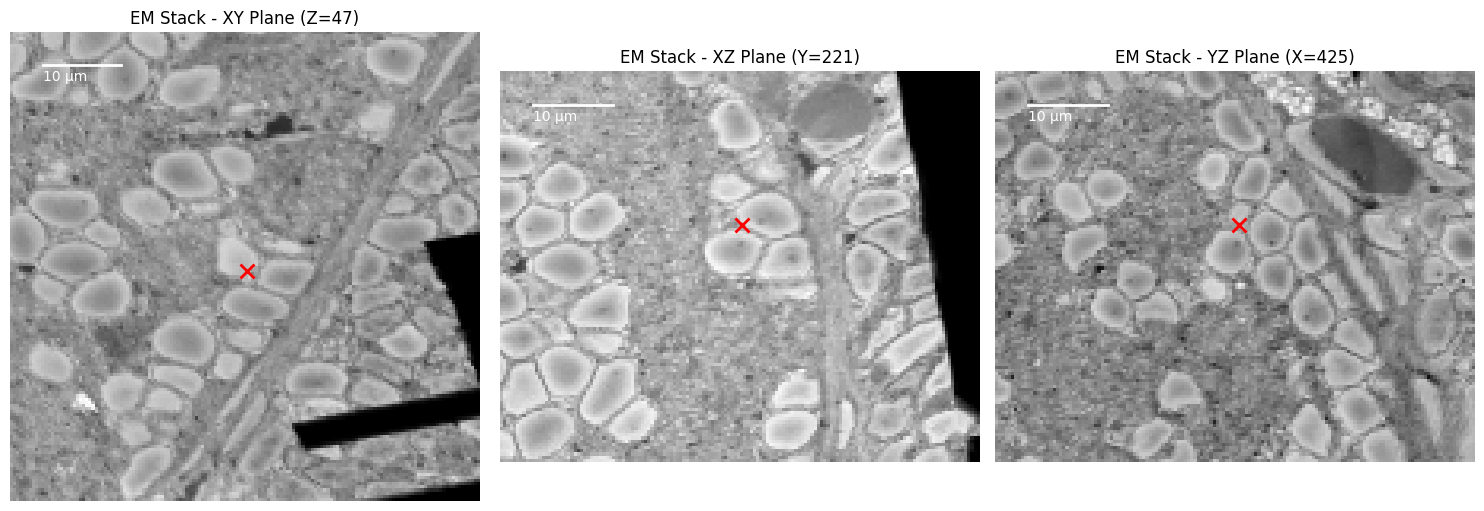

LM Stack Green crop size in voxels: [75, 75, 75]


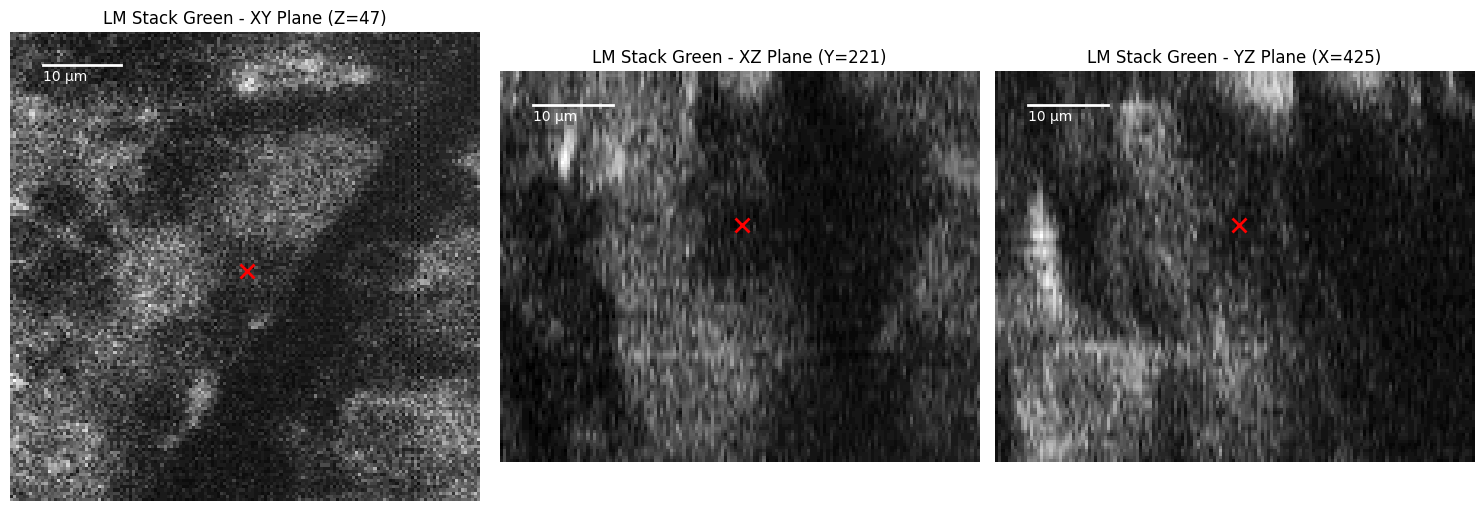

LM Stack Red crop size in voxels: [75, 75, 75]


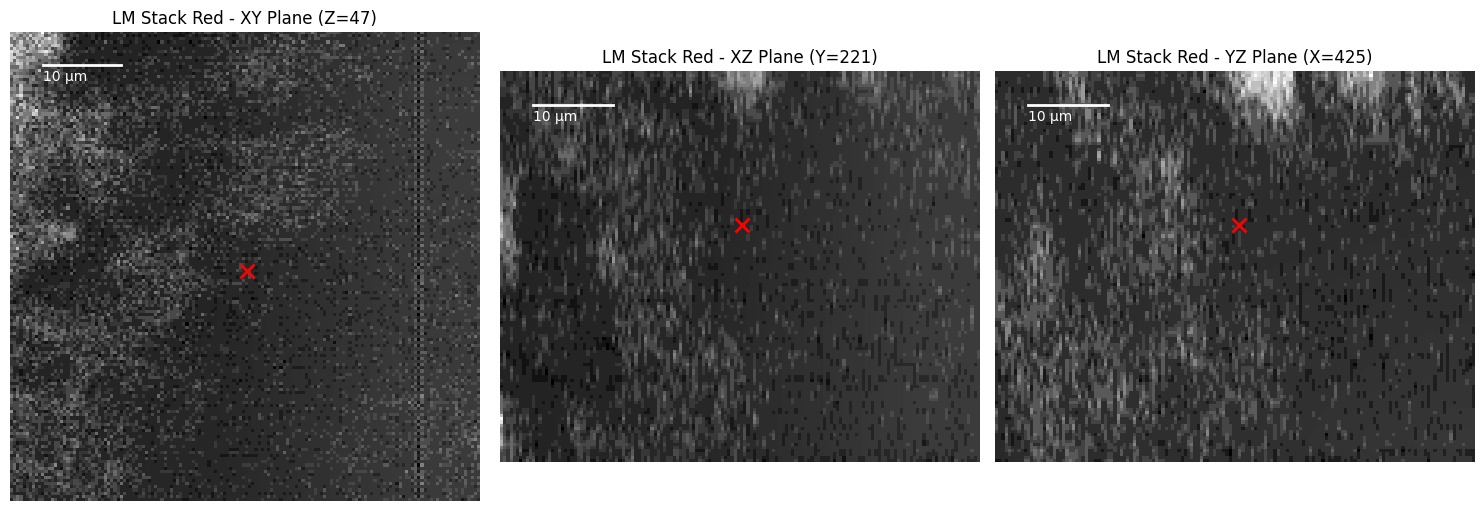

6 20.839080459770116 336.91379310344826
yes


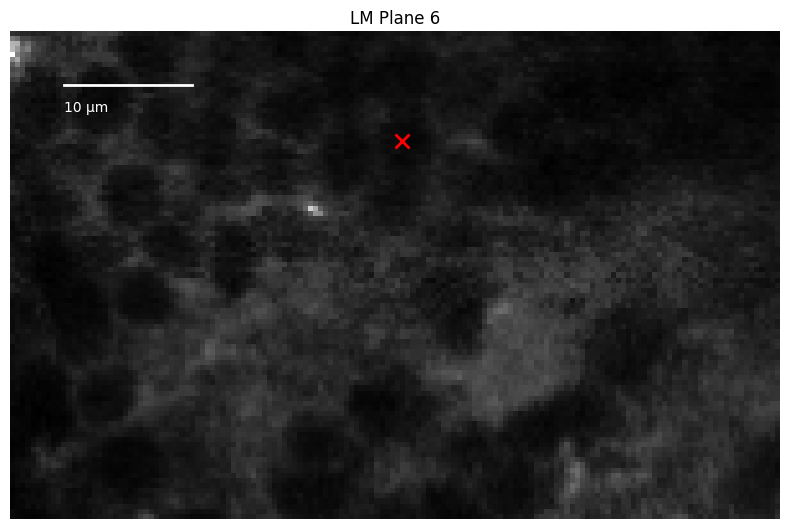

In [136]:

# Getting cell information
agglo_id = 122735082 #Good: 11110415, 109457145, 60212755,56176220      Bad: #122735082(plane6) #62870187

if agglo_id in df["agglo_id"].values:
    # Get the row for this cell
    cell_row = df[df["agglo_id"]==agglo_id]
    
    # Extract the centroids
    cell_em_centroid = cell_row["lm_centroid_bw"].values[0]
    cell_lm_centroid = cell_row["lm_centroid_bw"].values[0]
    cell_plane_centroid = cell_row["lm_centroid_plane_flip"].values[0]
    cell_g_coeff = cell_row["g_coeff"].values[0]
    cell_r_coeff = cell_row["r_coeff"].values[0]
    cell_inOB = cell_row["in_OB"].values[0]
    cell_ng_centroid = cell_row["em_centroid_ng"].values[0]
    cell_plane_bw_centroid = cell_row["lm_centroid_plane_bw"].values[0]

    print(f"EM centroid: {cell_em_centroid}")
    print(f"LM centroid: {cell_lm_centroid}")
    print(f"Plane centroid: {cell_plane_centroid}")
    print(f"Plane centroid warped: {cell_plane_bw_centroid}")

    print(f"g_coeff: {cell_g_coeff}")
    print(f"r_coeff: {cell_r_coeff}")
    print(f"in OB: {cell_inOB}")
    print(f"Neuroglancer coordinates (xyz): {cell_ng_centroid}")


else:
    print(f"Cell ID {agglo_id} not found in the dataframe")

# Define physical size in micrometers for the region of interest
physical_size_um = (30, 30, 30)
# Visualize EM data
visualize_stack(em_stack_warped, cell_em_centroid, em_stack_warped_voxel, "EM Stack")

# Visualize LM data
visualize_stack(lm_stack_bw[0], cell_lm_centroid, lm_stack_bw_voxel, "LM Stack Green")
visualize_stack(lm_stack_bw[1], cell_lm_centroid, lm_stack_bw_voxel, "LM Stack Red")


# Visualize LM plane if available
if cell_plane_centroid is not None and len(lm_planes_flipped) > 0:
    plane_idx, y, x = cell_plane_centroid
    plane_idx = int(plane_idx)
    print(plane_idx, y, x)
    if 0 <= plane_idx < len(lm_planes_flipped):
        print("yes")
        visualize_plane(lm_planes_flipped[plane_idx], [y, x], lm_planes_voxel, plane_idx)
    else:
        print(f"Invalid plane index: {plane_idx}. Available planes: 0-{len(lm_planes_flipped)-1}")


,neuron_id,em_centroid_bw,em_centroid_ds,em_centroid_ng,lm_centroid_bw,lm_centroid_plane_bw,lm_centroid_plane_flip,agglo_id,g_coeff,in_OB,lm_stack_bw_mask_label,r_coeff
79,1069,"[474.3600151745068, 211.50815629742033, 560.67...","[76.0, 560.0, 521.0]","[9515.239757207892, 11771.79817905918, 1224.86...","[58.99942514778259, 249.25596490973348, 308.74...","[42.16389792668319, 151.9465924792758, 285.584...","[6.0, 19.505494505494507, 289.61538461538464]",70255682,0.39925,True,1364,0.656045


In [30]:
print(plane_idx)
len(lm_planes_flipped[plane_idx])

6.0


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [47]:
vwlut = napari.Viewer()
vwlut.add_image(em_stack_warped, blending="additive")
vwlut.add_image(lm_stack_bw, blending="additive")
vwlut.add_image(lm_planes_flipped, blending="additive")
vwlut.add_points([plane_idx, y, x], blending="additive")

D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)
D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Points layer 'Points' at 0x21a9a5957b0>